In [2]:
# pip install progressbar
# pip install prettytable
# pip install tensorboardX

SyntaxError: invalid syntax (<ipython-input-2-a94c0ee34451>, line 1)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Processing...


/data1/User/anaconda3/envs/isgan/lib/python3.6/site-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!
Source


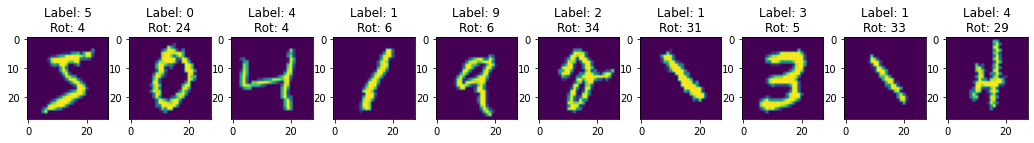

Sub Target #1


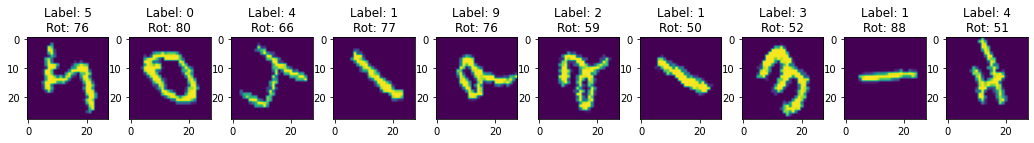

Sub Target #2


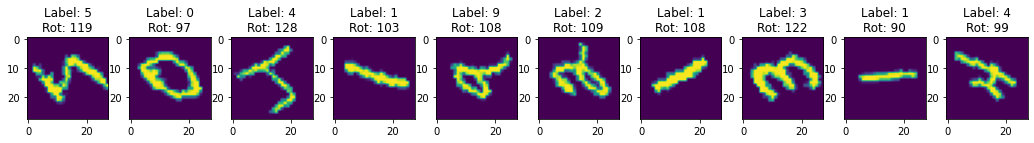

Sub Target #3


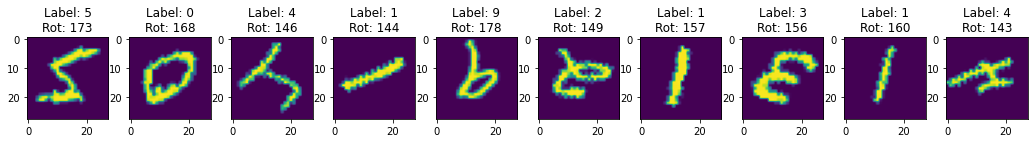

Sub Target #4


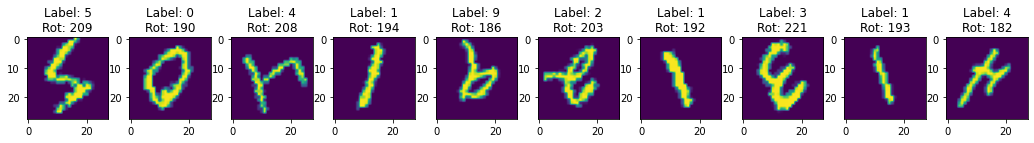

Sub Target #5


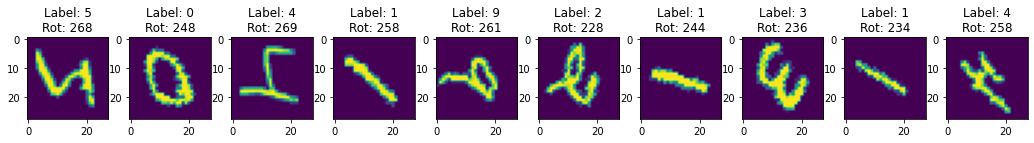

Sub Target #6


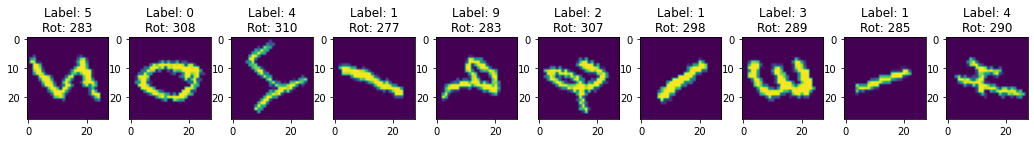

Sub Target #7


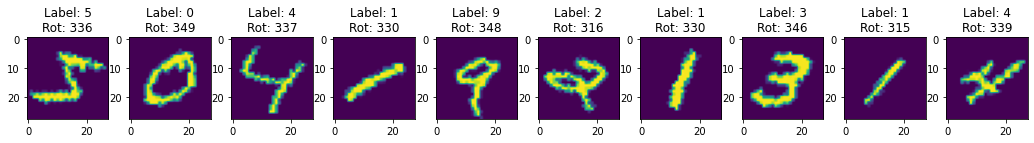

In [2]:
"""
Rotating MNIST dataset
Domain: anti-clockwise rotating angle (theta)
Source domains: theta in (0, 45 degree)
    Amount: 60000
Target domains: theta in (45, 360 degree)
    Amount: 60000 * 7
"""

"""
Download data if needed
"""
from model import download
download()

"""
Visualize the data
"""
import matplotlib.pyplot as plt
from model import RotateMNIST

for i in range(8):
    dataset = RotateMNIST(rotate_angle=(i*45,i*45+45))
    if i == 0:
        dname = 'Source'
    else:
        dname = f'Sub Target #{i}'
    print(dname)
    fig, ax = plt.subplots(1, 10, figsize=(18,1.5))
    for j in range(10):
        img, label, angle, _ = dataset[j]
        angle = angle[0] * 360
        ax[j].imshow(img[0])
        ax[j].set_title(f'Label: {label}\nRot: {angle:.0f}')
    plt.show()
    plt.close()

In [3]:
"""
Configurations
"""
%load_ext autoreload
%autoreload 2

from easydict import EasyDict
from model import set_default_args, print_args
from model import SO, ADDA, DANN, CUA, CIDA, PCIDA
from torch.utils.data import DataLoader

opt = EasyDict()
# choose the method from ["CIDA", "PCIDA", "SO", "ADDA", "DANN" "CUA"]
opt.model = "CIDA"
# choose run on which device ["cuda", "cpu"]
opt.device = "cuda"
set_default_args(opt)
print_args(opt)
# build dataset and data loader
dataset = RotateMNIST(rotate_angle=(0, 360))
train_dataloader = DataLoader(
    dataset=dataset,
    shuffle=True,
    batch_size=opt.batch_size,
    num_workers=4,
)
test_dataloader = DataLoader(
    dataset=dataset,
    shuffle=True,
    batch_size=opt.batch_size,
    num_workers=4,
)
# build model
model_pool = {
    'SO': SO,
    'CIDA': CIDA,
    'PCIDA': PCIDA,
    'ADDA': ADDA,
    'DANN': DANN,
    'CUA': CUA,
}
model = model_pool[opt.model](opt)
model = model.to(opt.device)

Traing result will be saved in  ./dump/RotatingMNIST_CIDA
model: CIDA
device: cuda
dropout: 0
nh: 512
nc: 10
nz: 100
num_epoch: 100
batch_size: 100
lr: 0.0002
weight_decay: 0.0005
beta1: 0.9
lambda_gan: 2.0
exp: RotatingMNIST_CIDA
outf: ./dump/RotatingMNIST_CIDA
dim_domain: 1
continual_da: False


In [4]:
"""
Training the model from the scratch
"""
best_acc_target = 0
if not opt.continual_da:
    # Single Step Domain Adaptation
    for epoch in range(opt.num_epoch):
        model.learn(epoch, train_dataloader)
        if (epoch + 1) % 10 == 0:
            acc_target = model.eval_mnist(test_dataloader)
            if acc_target > best_acc_target:
                print('Best acc target. saved.')
                model.save()
else:
    # continual DA training
    continual_dataset = ContinousRotateMNIST()

    print('===> pretrain the classifer')
    model.prepare_trainer(init=True)
    for epoch in range(opt.num_epoch_pre):
        model.learn(epoch, train_dataloader, init=True)
        if (epoch + 1) % 10 == 0:
            model.eval_mnist(test_dataloader)
    print('===> start continual DA')
    model.prepare_trainer(init=False)
    for phase in range(opt.num_da_step):
        continual_dataset.set_phase(phase)
        print(f'Phase {phase}/{opt.num_da_step}')
        print(f'#source {len(continual_dataset.ds_source)} #target {len(continual_dataset.ds_target[phase])} #replay {len(continual_dataset.ds_replay)}')
        continual_dataloader = DataLoader(
            dataset=continual_dataset,
            shuffle=True,
            batch_size=opt.batch_size,
            num_workers=4,
        )
        for epoch in range(opt.num_epoch_sub):
            model.learn(epoch, continual_dataloader, init=False)
            if (epoch + 1) % 10 == 0:
                model.eval_mnist(test_dataloader)

        target_dataloader = DataLoader(
            dataset=continual_dataset.ds_target[phase],
            shuffle=True,
            batch_size=opt.batch_size,
            num_workers=4,
        )
        acc_target = model.eval_mnist(test_dataloader)
        if acc_target > best_acc_target:
            print('Best acc target. saved.')
            model.save()
        data_tuple = model.gen_data_tuple(target_dataloader)
        continual_dataset.ds_replay.update(data_tuple)  


/data1/User/DomainBed/DRM/CIDA-master/rotatingMNIST/model.py:208: UserWarning: torch.symeig is deprecated in favor of torch.linalg.eigh and will be removed in a future PyTorch release.
The default behavior has changed from using the upper triangular portion of the matrix by default to using the lower triangular portion.
L, _ = torch.symeig(A, upper=upper)
should be replaced with
L = torch.linalg.eigvalsh(A, UPLO='U' if upper else 'L')
and
L, V = torch.symeig(A, eigenvectors=True)
should be replaced with
L, V = torch.linalg.eigh(A, UPLO='U' if upper else 'L') (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2500.)
  _, evs = torch.symeig(A, eigenvectors=True)
/data1/User/anaconda3/envs/isgan/lib/python3.6/site-packages/torch/nn/functional.py:4044: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for detail

In [1]:
"""
Load the pretrained model
"""
model.load()

NameError: name 'model' is not defined

In [6]:
"""
Print the model result
"""
model.gen_result_table(test_dataloader)

+----------+--------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+
| Accuracy | Source | Target #1 | Target #2 | Target #3 | Target #4 | Target #5 | Target #6 | Target #7 |
+----------+--------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+
| Class 0  |  99.7  |    99.0   |    96.8   |    96.5   |    96.8   |    98.3   |    99.1   |    98.9   |
| Class 1  |  99.8  |    97.2   |    97.4   |    96.1   |    96.5   |    98.5   |    98.9   |    98.9   |
| Class 2  |  99.7  |    90.8   |    64.0   |    68.4   |    66.7   |    81.9   |    97.9   |    93.4   |
| Class 3  |  99.6  |    92.7   |    82.1   |    86.4   |    87.7   |    95.2   |    97.0   |    98.5   |
| Class 4  |  98.6  |    87.1   |    68.0   |    73.5   |    73.2   |    70.2   |    91.8   |    94.3   |
| Class 5  |  99.5  |    89.5   |    73.9   |    74.0   |    71.6   |    79.4   |    94.8   |    96.2   |
| Class 6  |  99.6  |    90.1   |    58.1   | 